### Importing Necessary Libraries


In [1]:
from langchain_openai import ChatOpenAI 
from langchain_groq import ChatGroq
from langchain.document_loaders import  PyPDFLoader
from langchain.vectorstores import  FAISS
from langchain.text_splitter import  RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings 
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod

from langgraph.graph import END, StateGraph

from time import monotonic
from dotenv import load_dotenv
from pprint import pprint
import os
from datasets import Dataset
from typing_extensions import TypedDict
from IPython.display import display, Image
from typing import List, TypedDict

from ragas import evaluate
from ragas.metrics import (
    answer_correctness,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_similarity
)

import langgraph


### Helper functions for the notebook
from helper_functions import num_tokens_from_string, replace_t_with_space, replace_double_lines_with_one_line, split_into_chapters,\
analyse_metric_results, escape_quotes, text_wrap,extract_book_quotes_as_documents

load_dotenv()

os.environ["PYDEVD_WARN_EVALUATION_TIMEOUT"] = "100000"

### Setting Preferred Encoding for PyPDF ** ONLY FOR GOOGLE COLAB **


In [2]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding # For using PyPDF on google colab 

### Setting OPENAI and GROQ API keys

In [2]:
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')

# Data preprocessing

### Defining Path to Harry Potter PDF


In [3]:
hp_pdf_path ="Harry_Potter_Book_1_The_Sorcerers_Stone.pdf"

### Splitting the PDF into Chapters and Preprocessing


In [5]:
chapters = split_into_chapters(hp_pdf_path) 
chapters = replace_t_with_space(chapters)
print(len(chapters))

17


### Creating a list of quotes taken from the book

In [4]:
loader = PyPDFLoader(hp_pdf_path)
document = loader.load()
document_cleaned = replace_t_with_space(document)
book_quotes_list = extract_book_quotes_as_documents(document_cleaned)

### Defining Prompt Template for Summarization


In [6]:
summarization_prompt_template = """Write an extensive summary of the following:

{text}

SUMMARY:"""

summarization_prompt = PromptTemplate(template=summarization_prompt_template, input_variables=["text"])

### Defining Function to Create Chapter Summaries using LLMs


In [7]:
def create_chapter_summary(chapter):
    """
    Creates a summary of a chapter using a large language model (LLM).

    Args:
        chapter: A Document object representing the chapter to summarize.

    Returns:
        A Document object containing the summary of the chapter.
    """

    chapter_txt = chapter.page_content  # Extract chapter text
    model_name = "gpt-3.5-turbo-0125"  # Specify LLM model
    llm = ChatOpenAI(temperature=0, model_name=model_name)  # Create LLM instance
    gpt_35_turbo_max_tokens = 16000  # Maximum token limit for the LLM
    verbose = False  # Set to True for more detailed output

    # Calculate number of tokens in the chapter text
    num_tokens = num_tokens_from_string(chapter_txt, model_name)

    # Choose appropriate chain type based on token count
    if num_tokens < gpt_35_turbo_max_tokens:
        chain = load_summarize_chain(llm, chain_type="stuff", prompt=summarization_prompt, verbose=verbose) 
    else:
        chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=summarization_prompt, combine_prompt=summarization_prompt, verbose=verbose)

    start_time = monotonic()  # Start timer
    doc_chapter = Document(page_content=chapter_txt)  # Create Document object for chapter
    summary = chain.invoke([doc_chapter])  # Generate summary using the chain
    print(f"Chain type: {chain.__class__.__name__}")  # Print chain type
    print(f"Run time: {monotonic() - start_time}")  # Print execution time

    # Clean up summary text
    summary = replace_double_lines_with_one_line(summary["output_text"])

    # Create Document object for summary
    doc_summary = Document(page_content=summary, metadata=chapter.metadata)

    return doc_summary

### Generating Summaries for Each Chapter


In [ ]:
chapter_summaries = []
for chapter in chapters:
    chapter_summaries.append(create_chapter_summary(chapter))

# Encoding the data

### Function to Encode a Book into a Vector Store using OpenAI Embeddings


In [9]:
def encode_book(path, chunk_size=1000, chunk_overlap=200):
    """
    Encodes a PDF book into a vector store using OpenAI embeddings.

    Args:
        path: The path to the PDF file.
        chunk_size: The desired size of each text chunk.
        chunk_overlap: The amount of overlap between consecutive chunks.

    Returns:
        A FAISS vector store containing the encoded book content.
    """

    # Load PDF documents
    loader = PyPDFLoader(path)
    documents = loader.load()

    # Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )
    texts = text_splitter.split_documents(documents)
    cleaned_texts = replace_t_with_space(texts)

    # Create embeddings and vector store
    embeddings = OpenAIEmbeddings()
    vectorstore = FAISS.from_documents(cleaned_texts, embeddings)

    return vectorstore

### Encoding Chapter Summaries into Vector Store


In [10]:
def encode_chapter_summaries(chapter_summaries):
    """
    Encodes a list of chapter summaries into a vector store using OpenAI embeddings.

    Args:
        chapter_summaries: A list of Document objects representing the chapter summaries.

    Returns:
        A FAISS vector store containing the encoded chapter summaries.
    """

    embeddings = OpenAIEmbeddings()  # Create OpenAI embeddings
    chapter_summaries_vectorstore = FAISS.from_documents(chapter_summaries, embeddings)  # Create vector store
    return chapter_summaries_vectorstore

### Encoding Quotes into Vector Store

In [5]:
def encode_quotes(book_quotes_list):
    """
    Encodes a list of quotes into a vector store using OpenAI embeddings.

    Args:
        quote_list: A list of quotes.

    Returns:
        A FAISS vector store containing the encoded quotes.
    """

    embeddings = OpenAIEmbeddings()  # Create OpenAI embeddings
    quotes_vectorstore = FAISS.from_documents(book_quotes_list, embeddings)  # Create vector store
    return quotes_vectorstore

# Creating vector stores and retrievers 

### Creating Vector Stores and Retrievers for Book and Chapter Summaries


In [7]:
# ### IF VECTOR STORES ALREADY EXIST, LOAD THEM
if os.path.exists("chunks_vector_store") and os.path.exists("chapter_summaries_vector_store") and os.path.exists("book_quotes_vectorstore"):
    embeddings = OpenAIEmbeddings()
    chunks_vector_store =  FAISS.load_local("chunks_vector_store", embeddings, allow_dangerous_deserialization=True)
    chapter_summaries_vector_store =  FAISS.load_local("chapter_summaries_vector_store", embeddings, allow_dangerous_deserialization=True)
    book_quotes_vectorstore =  FAISS.load_local("book_quotes_vectorstore", embeddings, allow_dangerous_deserialization=True)

else:
    # Encode the book and chapter summaries
    chunks_vector_store = encode_book(hp_pdf_path, chunk_size=1000, chunk_overlap=200)
    chapter_summaries_vector_store = encode_chapter_summaries(chapter_summaries)
    book_quotes_vectorstore = encode_quotes(book_quotes_list)


    # Save the vector stores
    chunks_vector_store.save_local("chunks_vector_store")
    chapter_summaries_vector_store.save_local("chapter_summaries_vector_store")
    book_quotes_vectorstore.save_local("book_quotes_vectorstore")

### Create retrievers from the vector stores

In [8]:
chunks_query_retriever = chunks_vector_store.as_retriever(search_kwargs={"k": 1})     
chapter_summaries_query_retriever = chapter_summaries_vector_store.as_retriever(search_kwargs={"k": 1})
book_quotes_query_retriever = book_quotes_vectorstore.as_retriever(search_kwargs={"k": 10})

# For advanced RAGing
## For questions that can be answered by retrieval based on the original query, we create a `langgraph` graph for answering the query.


### Agrregate retrieved content as string context

In [29]:
def retrieve_context_per_question(state):
    """
    Retrieves relevant context for a given question. The context is retrieved from the book chunks and chapter summaries.

    Args:
        state: A dictionary containing the question to answer.
    """
    # Retrieve relevant documents
    print("Retrieving relevant chunks...")
    question = state["question"]
    docs = chunks_query_retriever.get_relevant_documents(question)

    # Concatenate document content
    context = " ".join(doc.page_content for doc in docs)



    print("Retrieving relevant chapter summaries...")
    docs_summaries = chapter_summaries_query_retriever.get_relevant_documents(state["question"])

    # Concatenate chapter summaries with citation information
    context_summaries = " ".join(
        f"{doc.page_content} (Chapter {doc.metadata['chapter']})" for doc in docs_summaries
    )

    print("Retrieving relevant book quotes...")
    docs_book_quotes = book_quotes_query_retriever.get_relevant_documents(state["question"])
    book_qoutes = " ".join(doc.page_content for doc in docs_book_quotes)


    all_contexts = context + context_summaries + book_qoutes
    all_contexts = escape_quotes(all_contexts)

    return {"context": all_contexts, "question": question}

### LLM based function to distill only relevant retrieved content

In [30]:
keep_only_relevant_content_prompt_template = """you receive a query: {query} and retrieved documents: {retrieved_documents} from a
 vector store.
 You need to filter out all the non relevant information that don't supply important information regarding the {query}.
 your goal is just to filter out the non relevant information.
 you can remove parts of sentences that are not relevant to the query or remove whole sentences that are not relevant to the query.
 DO NOT ADD ANY NEW INFORMATION THAT IS NOT IN THE RETRIEVED DOCUMENTS.
 output the filtered relevant content.
"""


class KeepRelevantContent(BaseModel):
    relevant_content: str = Field(description="The relevant content from the retrieved documents that is relevant to the query.")

keep_only_relevant_content_prompt = PromptTemplate(
    template=keep_only_relevant_content_prompt_template,
    input_variables=["query", "retrieved_documents"],
)


keep_only_relevant_content_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)
keep_only_relevant_content_chain = keep_only_relevant_content_prompt | keep_only_relevant_content_llm.with_structured_output(KeepRelevantContent)


def keep_only_relevant_content(state):
    """
    Keeps only the relevant content from the retrieved documents that is relevant to the query.

    Args:
        question: The query question.
        context: The retrieved documents.
        chain: The LLMChain instance.

    Returns:
        The relevant content from the retrieved documents that is relevant to the query.
    """
    question = state["question"]
    context = state["context"]

    input_data = {
    "query": question,
    "retrieved_documents": context
}
    print("keeping only the relevant content...")
    pprint("--------------------")
    output = keep_only_relevant_content_chain.invoke(input_data)
    relevant_content = output.relevant_content
    relevant_content = "".join(relevant_content)
    relevant_content = escape_quotes(relevant_content)

    return {"relevant_context": relevant_content, "context": context, "question": question}

### LLM based function to re-write a question

In [31]:
class RewriteQuestion(BaseModel):
    """
    Output schema for the rewritten question.
    """
    rewritten_question: str = Field(description="The improved question optimized for vectorstore retrieval.")
    explanation: str = Field(description="The explanation of the rewritten question.")

rewrite_question_string_parser = JsonOutputParser(pydantic_object=RewriteQuestion)


rewrite_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)
rewrite_prompt_template = """You are a question re-writer that converts an input question to a better version optimized for vectorstore retrieval.
 Analyze the input question {question} and try to reason about the underlying semantic intent / meaning.
 {format_instructions}
 """

rewrite_prompt = PromptTemplate(
    template=rewrite_prompt_template,
    input_variables=["question"],
    partial_variables={"format_instructions": rewrite_question_string_parser.get_format_instructions()},
)

question_rewriter = rewrite_prompt | rewrite_llm | rewrite_question_string_parser  # Combine prompt, LLM, and parser

def rewrite_question(state):
    """Rewrites the given question using the LLM.

    Args:
        state: A dictionary containing the question to rewrite.
    """
    question = state["question"]
    print("Rewriting the question...")
    result = question_rewriter.invoke({"question": question})
    new_question = result["rewritten_question"]
    return {"question": new_question}

### LLM based function to answer a question given context, using Chain of Thought

In [32]:
class QuestionAnswerFromContext(BaseModel):
    answer_based_on_content: str = Field(description="generates an answer to a query based on a given context.")

question_answer_from_context_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)


question_answer_cot_prompt_template = """ 
Examples of Chain-of-Thought Reasoning

Example 1

Context: Mary is taller than Jane. Jane is shorter than Tom. Tom is the same height as David.
Question: Who is the tallest person?
Reasoning Chain:
The context tells us Mary is taller than Jane
It also says Jane is shorter than Tom
And Tom is the same height as David
So the order from tallest to shortest is: Mary, Tom/David, Jane
Therefore, Mary must be the tallest person

Example 2
Context: Harry was reading a book about magic spells. One spell allowed the caster to turn a person into an animal for a short time. Another spell could levitate objects.
 A third spell created a bright light at the end of the caster's wand.
Question: Based on the context, if Harry cast these spells, what could he do?
Reasoning Chain:
The context describes three different magic spells
The first spell allows turning a person into an animal temporarily
The second spell can levitate or float objects
The third spell creates a bright light
If Harry cast these spells, he could turn someone into an animal for a while, make objects float, and create a bright light source
So based on the context, if Harry cast these spells he could transform people, levitate things, and illuminate an area
Instructions.

Example 3 
Context: Harry Potter woke up on his birthday to find a present at the end of his bed. He excitedly opened it to reveal a Nimbus 2000 broomstick.
Question: Why did Harry receive a broomstick for his birthday?
Reasoning Chain:
The context states that Harry Potter woke up on his birthday and received a present - a Nimbus 2000 broomstick.
However, the context does not provide any information about why he received that specific present or who gave it to him.
There are no details about Harry's interests, hobbies, or the person who gifted him the broomstick.
Without any additional context about Harry's background or the gift-giver's motivations, there is no way to determine the reason he received a broomstick as a birthday present.

For the question below, provide your answer by first showing your step-by-step reasoning process, breaking down the problem into a chain of thought before arriving at the final answer,
 just like in the previous examples.
Context
{context}
Question
{question}
"""

question_answer_from_context_cot_prompt = PromptTemplate(
    template=question_answer_cot_prompt_template,
    input_variables=["context", "question"],
)
question_answer_from_context_cot_chain = question_answer_from_context_cot_prompt | question_answer_from_context_llm.with_structured_output(QuestionAnswerFromContext)


def answer_question_from_context(state):
    """
    Answers a question from a given context.

    Args:
        question: The query question.
        context: The context to answer the question from.
        chain: The LLMChain instance.

    Returns:
        The answer to the question from the context.
    """
    question = state["question"]
    context = state["aggregated_context"] if "aggregated_context" in state else state["context"]

    input_data = {
    "question": question,
    "context": context
}
    print("Answering the question from the retrieved context...")

    output = question_answer_from_context_cot_chain.invoke(input_data)
    answer = output.answer_based_on_content
    print(f'answer before checking hallucination: {answer}')
    return {"answer": answer, "context": context, "question": question}

## Create graph edges

### LLM based function to determine if retrieved content is relevant to the question

In [33]:
is_relevant_content_prompt_template = """you receive a query: {query} and a context: {context} retrieved from a vector store. 
You need to determine if the document is relevant to the query. 

{format_instructions}"""

class Relevance(BaseModel):
    is_relevant: bool = Field(description="Whether the document is relevant to the query.")
    explanation: str = Field(description="An explanation of why the document is relevant or not.")

is_relevant_json_parser = JsonOutputParser(pydantic_object=Relevance)
is_relevant_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)

is_relevant_content_prompt = PromptTemplate(
    template=is_relevant_content_prompt_template,
    input_variables=["query", "context"],
    partial_variables={"format_instructions": is_relevant_json_parser.get_format_instructions()},
)
is_relevant_content_chain = is_relevant_content_prompt | is_relevant_llm | is_relevant_json_parser

def is_relevant_content(state):
    """
    Determines if the document is relevant to the query.

    Args:
        question: The query question.
        context: The context to determine relevance.
    """

    question = state["question"]
    context = state["context"]

    input_data = {
    "query": question,
    "context": context
}

    # Invoke the chain to determine if the document is relevant
    output = is_relevant_content_chain.invoke(input_data)
    print("Determining if the document is relevant...")
    if output["is_relevant"] == True:
        print("The document is relevant.")
        return "relevant"
    else:
        print("The document is not relevant.")
        return "not relevant"

### LLM chain to check if an answer is a hallucination or grounded on facts

In [34]:
class is_grounded_on_facts(BaseModel):
    """
    Output schema for the rewritten question.
    """
    grounded_on_facts: bool = Field(description="Answer is grounded in the facts, 'yes' or 'no'")

is_grounded_on_facts_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)
is_grounded_on_facts_prompt_template = """You are a fact-checker that determines if the given answer {answer} is grounded in the given context {context}
you don't mind if it doesn't make sense, as long as it is grounded in the context.
output a json containing the answer to the question, and appart from the json format don't output any additional text.

 """
is_grounded_on_facts_prompt = PromptTemplate(
    template=is_grounded_on_facts_prompt_template,
    input_variables=["context", "answer"],
)
is_grounded_on_facts_chain = is_grounded_on_facts_prompt | is_grounded_on_facts_llm.with_structured_output(is_grounded_on_facts)

### LLM chain to determine if a question can be fully answered given a context

In [35]:
can_be_answered_prompt_template = """You receive a query: {question} and a context: {context}. 
You need to determine if the question can be fully answered based on the context.
{format_instructions}
"""

class QuestionAnswer(BaseModel):
    can_be_answered: bool = Field(description="binary result of whether the question can be fully answered or not")
    explanation: str = Field(description="An explanation of why the question can be fully answered or not.")

can_be_answered_json_parser = JsonOutputParser(pydantic_object=QuestionAnswer)

answer_question_prompt = PromptTemplate(
    template=can_be_answered_prompt_template,
    input_variables=["question","context"],
    partial_variables={"format_instructions": can_be_answered_json_parser.get_format_instructions()},
)

can_be_answered_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)
can_be_answered_chain = answer_question_prompt | can_be_answered_llm | can_be_answered_json_parser

### function to check both cases - hallucination and full answer

In [36]:
def grade_generation_v_documents_and_question(state):
    """
    Grades the generation of the answer to the question based on the context, if it is grounded in the facts, and if the question can be fully answered

    Args:
        state: A dictionary containing the context, question, and answer.
    """
    
    print("Checking if the answer is grounded in the facts...")
    context = state["context"]
    answer = state["answer"]
    question = state["question"]
    
    result = is_grounded_on_facts_chain.invoke({"context": context, "answer": answer})
    grounded_on_facts = result.grounded_on_facts
    if not grounded_on_facts:
        print("The answer is hallucination.")
        return "hallucination"
    else:
        print("The answer is grounded in the facts.")

        input_data = {
            "question": question,
            "context": context
        }

        # Invoke the chain to determine if the question can be answered
        print("Determining if the question is fully answered...")
        output = can_be_answered_chain.invoke(input_data)
        can_be_answered = output["can_be_answered"]
        if can_be_answered == True:
            print("The question can be fully answered.")
            return "useful"
        else:
            print("The question cannot be fully answered.")
            return "not_useful"

### Test a pipeline of all parts

In [179]:
init_state = {"question": "who is fluffy?"}  # The question to answer
context_state = retrieve_context_per_question(init_state)  # Retrieve context for the question
relevant_content_state = keep_only_relevant_content(context_state)  # Keep only the relevant content
is_relevant_content_state = is_relevant_content(relevant_content_state) # Check if the content is relevant
answer_state = answer_question_from_context(relevant_content_state) # Answer the question from the context
final_answer = grade_generation_v_documents_and_question(answer_state) # Grade the answer
print(answer_state["answer"])

Retrieving relevant chunks...
Retrieving relevant chapter summaries...
keeping only the relevant content...
'--------------------'
Determining if the document is relevant...
The document is relevant.
Answering the question from the retrieved context...
answer before checking hallucination: Fluffy is a three-headed dog.
Checking if the answer is grounded in the facts...
The answer is grounded in the facts.
Determining if the question is fully answered...
The question can be fully answered.
Fluffy is a three-headed dog.


### Build the Graph

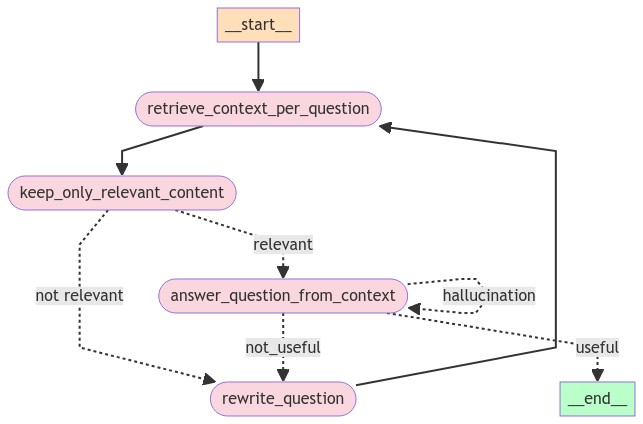

In [37]:
class QualitativeRetievalAnswerGraphState(TypedDict):

    question: str
    context: str
    answer: str

# Create the graph
qualitative_retrieval_answer_workflow = StateGraph(QualitativeRetievalAnswerGraphState)

# Define the nodes

# Add the nodes to the graph
qualitative_retrieval_answer_workflow.add_node("retrieve_context_per_question",retrieve_context_per_question)
qualitative_retrieval_answer_workflow.add_node("keep_only_relevant_content",keep_only_relevant_content)
qualitative_retrieval_answer_workflow.add_node("rewrite_question",rewrite_question)
qualitative_retrieval_answer_workflow.add_node("answer_question_from_context",answer_question_from_context)

# Build the graph
qualitative_retrieval_answer_workflow.set_entry_point("retrieve_context_per_question")
qualitative_retrieval_answer_workflow.add_edge("retrieve_context_per_question", "keep_only_relevant_content")
qualitative_retrieval_answer_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_relevant_content,
    {"relevant":"answer_question_from_context",
      "not relevant":"rewrite_question"},
    )
qualitative_retrieval_answer_workflow.add_edge("rewrite_question", "retrieve_context_per_question")
qualitative_retrieval_answer_workflow.add_conditional_edges(
"answer_question_from_context",
grade_generation_v_documents_and_question,
{"hallucination":"answer_question_from_context",
"not_useful":"rewrite_question",
"useful":END},
)

qualitative_retrieval_answer_retrival_app = qualitative_retrieval_answer_workflow.compile()

display(
    Image(
        qualitative_retrieval_answer_retrival_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

# For more complex tasks, where the question cannot be answered solely by retrieving information based on semantic similarity, we need a more sophisticated pipeline. To achieve this, we may first break down the graph into several sub-graphs that will serve as functions for the sophisticated pipeline.







### Let's add a function that Verifies that the distilled content is grounded in the original context

In [38]:
is_distilled_content_grounded_on_content_prompt_template = """you receive some distilled content: {distilled_content} and the original context: {original_context}.
    you need to determine if the distilled content is grounded on the original context.
    if the distilled content is grounded on the original context, set the grounded field to true.
    if the distilled content is not grounded on the original context, set the grounded field to false. {format_instructions}"""
  

class IsDistilledContentGroundedOnContent(BaseModel):
    grounded: bool = Field(description="Whether the distilled content is grounded on the original context.")
    explanation: str = Field(description="An explanation of why the distilled content is or is not grounded on the original context.")

is_distilled_content_grounded_on_content_json_parser = JsonOutputParser(pydantic_object=IsDistilledContentGroundedOnContent)

is_distilled_content_grounded_on_content_prompt = PromptTemplate(
    template=is_distilled_content_grounded_on_content_prompt_template,
    input_variables=["distilled_content", "original_context"],
    partial_variables={"format_instructions": is_distilled_content_grounded_on_content_json_parser.get_format_instructions()},
)

is_distilled_content_grounded_on_content_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)

is_distilled_content_grounded_on_content_chain = is_distilled_content_grounded_on_content_prompt | is_distilled_content_grounded_on_content_llm | is_distilled_content_grounded_on_content_json_parser


def is_distilled_content_grounded_on_content(state):
    pprint("--------------------")

    """
    Determines if the distilled content is grounded on the original context.

    Args:
        distilled_content: The distilled content.
        original_context: The original context.

    Returns:
        Whether the distilled content is grounded on the original context.
    """

    print("Determining if the distilled content is grounded on the original context...")
    distilled_content = state["relevant_context"]
    original_context = state["context"]

    input_data = {
        "distilled_content": distilled_content,
        "original_context": original_context
    }

    output = is_distilled_content_grounded_on_content_chain.invoke(input_data)
    grounded = output["grounded"]

    if grounded:
        print("The distilled content is grounded on the original context.")
        return "grounded on the original context"
    else:
        print("The distilled content is not grounded on the original context.")
        return "not grounded on the original context"

### Create functions for each type of retrieval

In [46]:
def retrieve_chunks_context_per_question(state):
    """
    Retrieves relevant context for a given question. The context is retrieved from the book chunks and chapter summaries.

    Args:
        state: A dictionary containing the question to answer.
    """
    # Retrieve relevant documents
    print("Retrieving relevant chunks...")
    question = state["question"]
    docs = chunks_query_retriever.get_relevant_documents(question)

    # Concatenate document content
    context = " ".join(doc.page_content for doc in docs)
    context = escape_quotes(context)
    return {"context": context, "question": question}

def retrieve_summaries_context_per_question(state):

    print("Retrieving relevant chapter summaries...")
    question = state["question"]

    docs_summaries = chapter_summaries_query_retriever.get_relevant_documents(state["question"])

    # Concatenate chapter summaries with citation information
    context_summaries = " ".join(
        f"{doc.page_content} (Chapter {doc.metadata['chapter']})" for doc in docs_summaries
    )
    context_summaries = escape_quotes(context_summaries)
    return {"context": context_summaries, "question": question}

def retrieve_book_quotes_context_per_question(state):
    question = state["question"]

    print("Retrieving relevant book quotes...")
    docs_book_quotes = book_quotes_query_retriever.get_relevant_documents(state["question"])
    book_qoutes = " ".join(doc.page_content for doc in docs_book_quotes)
    book_qoutes_context = escape_quotes(book_qoutes)

    return {"context": book_qoutes_context, "question": question}

## Create sub graph for each type of retrieval

### The first sub-graph would be for retrieval and distillation of the relevant information with some modification

In [54]:
class QualitativeRetrievalGraphState(TypedDict):
    """
    Represents the state of our graph.
    """

    question: str
    context: str
    relevant_context: str

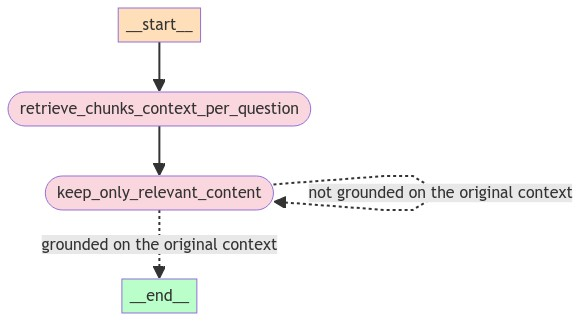

In [61]:
qualitative_chunks_retrieval_workflow = StateGraph(QualitativeRetrievalGraphState)

# Define the nodes
qualitative_chunks_retrieval_workflow.add_node("retrieve_chunks_context_per_question",retrieve_chunks_context_per_question)
qualitative_chunks_retrieval_workflow.add_node("keep_only_relevant_content",keep_only_relevant_content)

# Build the graph
qualitative_chunks_retrieval_workflow.set_entry_point("retrieve_chunks_context_per_question")

qualitative_chunks_retrieval_workflow.add_edge("retrieve_chunks_context_per_question", "keep_only_relevant_content")

qualitative_chunks_retrieval_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_distilled_content_grounded_on_content,
    {"grounded on the original context":END,
      "not grounded on the original context":"keep_only_relevant_content"},
    )


qualitative_chunks_retrieval_workflow_app = qualitative_chunks_retrieval_workflow.compile()

display(
    Image(
        qualitative_chunks_retrieval_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

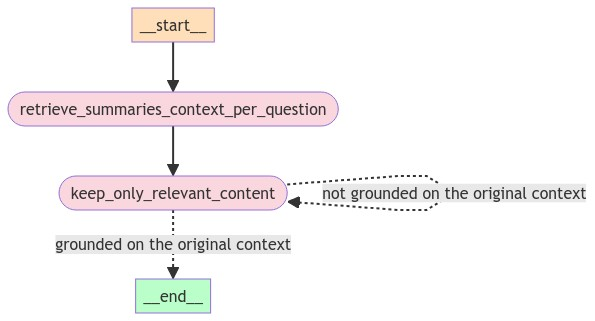

In [62]:
qualitative_summaries_retrieval_workflow = StateGraph(QualitativeRetrievalGraphState)

# Define the nodes
qualitative_summaries_retrieval_workflow.add_node("retrieve_summaries_context_per_question",retrieve_summaries_context_per_question)
qualitative_summaries_retrieval_workflow.add_node("keep_only_relevant_content",keep_only_relevant_content)

# Build the graph
qualitative_summaries_retrieval_workflow.set_entry_point("retrieve_summaries_context_per_question")

qualitative_summaries_retrieval_workflow.add_edge("retrieve_summaries_context_per_question", "keep_only_relevant_content")

qualitative_summaries_retrieval_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_distilled_content_grounded_on_content,
    {"grounded on the original context":END,
      "not grounded on the original context":"keep_only_relevant_content"},
    )


qualitative_summaries_retrieval_workflow_app = qualitative_summaries_retrieval_workflow.compile()

display(
    Image(
        qualitative_summaries_retrieval_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

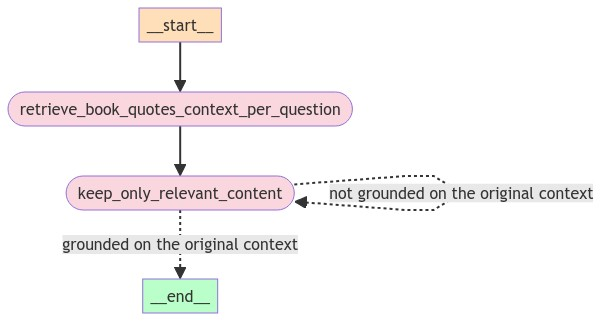

In [63]:
qualitative_book_quotes_retrieval_workflow = StateGraph(QualitativeRetrievalGraphState)

# Define the nodes
qualitative_book_quotes_retrieval_workflow.add_node("retrieve_book_quotes_context_per_question",retrieve_book_quotes_context_per_question)
qualitative_book_quotes_retrieval_workflow.add_node("keep_only_relevant_content",keep_only_relevant_content)

# Build the graph
qualitative_book_quotes_retrieval_workflow.set_entry_point("retrieve_book_quotes_context_per_question")

qualitative_book_quotes_retrieval_workflow.add_edge("retrieve_book_quotes_context_per_question", "keep_only_relevant_content")

qualitative_book_quotes_retrieval_workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_distilled_content_grounded_on_content,
    {"grounded on the original context":END,
      "not grounded on the original context":"keep_only_relevant_content"},
    )

qualitative_book_quotes_retrieval_workflow_app = qualitative_book_quotes_retrieval_workflow.compile()

display(
    Image(
        qualitative_book_quotes_retrieval_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Test the retreive-and-keep-relevant-content graphs

In [72]:
init_state = {"question": "worse than getting killed"}  # The question to answer

In [ ]:
## test the book chunks retrieval
for output in qualitative_chunks_retrieval_workflow_app.stream(init_state):    
    for _, value in output.items():
        pass 
    pprint("--------------------")
print(f'relevant context: {value["relevant_context"]}')

In [ ]:
## test the chapter summaries retrieval
for output in qualitative_summaries_retrieval_workflow_app.stream(init_state):    
    for _, value in output.items():
        pass 
    pprint("--------------------")
print(f'relevant context: {value["relevant_context"]}')

In [ ]:
## test the book quotes retrieval
for output in qualitative_book_quotes_retrieval_workflow_app.stream(init_state):    
    for _, value in output.items():
        pass 
    pprint("--------------------")
print(f'relevant context: {value["relevant_context"]}')

### Add a shorter version of the answer verification, checking only if grounded on context

In [78]:
def is_answer_grounded_on_context(state):
    """Determines if the answer to the question is grounded in the facts.
    
    Args:
        state: A dictionary containing the context and answer.
    """
    print("Checking if the answer is grounded in the facts...")
    context = state["context"]
    answer = state["answer"]
    
    result = is_grounded_on_facts_chain.invoke({"context": context, "answer": answer})
    grounded_on_facts = result.grounded_on_facts
    if not grounded_on_facts:
        print("The answer is hallucination.")
        return "hallucination"
    else:
        print("The answer is grounded in the facts.")
        return "grounded on context"

### The last sub-graph will be a component that answers a question given context, without hallucinations

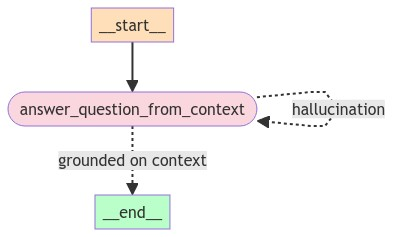

In [79]:
class QualitativeAnswerGraphState(TypedDict):
    """
    Represents the state of our graph.

    """

    question: str
    context: str
    answer: str

qualitative_answer_workflow = StateGraph(QualitativeAnswerGraphState)

# Define the nodes

qualitative_answer_workflow.add_node("answer_question_from_context",answer_question_from_context)

# Build the graph
qualitative_answer_workflow.set_entry_point("answer_question_from_context")

qualitative_answer_workflow.add_conditional_edges(
"answer_question_from_context",is_answer_grounded_on_context ,{"hallucination":"answer_question_from_context", "grounded on context":END}

)

qualitative_answer_workflow_app = qualitative_answer_workflow.compile()

display(
    Image(
        qualitative_answer_workflow_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Test the answer-from-question-graph

In [81]:
question = "who is harry?" # The question to answer
context = "Harry Potter is a cat." # The context to answer the question from
init_state = {"question": question, "context": context} # The initial state
for output in qualitative_answer_workflow_app.stream(init_state): 
    for _, value in output.items():
        pass  # Node
        # ... (your existing code)
    pprint("--------------------")
print(f'answer: {value["answer"]}')

Answering the question from the retrieved context...
answer before checking hallucination: The context states that Harry Potter is a cat. Therefore, Harry is a cat.
Checking if the answer is grounded in the facts...
The answer is grounded in the facts.
'--------------------'
answer: The context states that Harry Potter is a cat. Therefore, Harry is a cat.


# Now let's define the sophisticated pipline components

### The state of each step of the graph should be in this structure:

In [82]:
class PlanExecute(TypedDict):
    curr_state: str
    question: str
    anonymized_question: str
    query_to_retrieve_or_answer: str
    plan: List[str]
    past_steps: List[str]
    mapping: dict 
    curr_context: str
    aggregated_context: str
    tool: str
    response: str

### Define the Plan node - constructs a plan composed of steps, of how to tackle a question

In [83]:
class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

planner_prompt =""" For the given query {question}, come up with a simple step by step plan of how to figure out the answer. 

This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. 
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

"""

planner_prompt = PromptTemplate(
    template=planner_prompt,
      input_variables=["question"], 
     )

planner_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)

planner = planner_prompt | planner_llm.with_structured_output(Plan)

### A function to break down each task to either retrieve or answer

In [84]:
break_down_plan_prompt_template = """You receive a plan {plan} which contains a series of steps to follow in order to answer a query. 
you need to go through the plan refine it according to this:
1. every step has to be able to be executed by either:
    i. retrieving relevant information from a vector store of book chunks
    ii. retrieving relevant information from a vector store of chapter summaries
    iii. retrieving relevant information from a vector store of book quotes
    iv. answering a question from a given context.
2. every step should contain all the information needed to execute it.

output the refined plan
"""

break_down_plan_prompt = PromptTemplate(
    template=break_down_plan_prompt_template,
    input_variables=["plan"],
)

break_down_plan_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)

break_down_plan_chain = break_down_plan_prompt | break_down_plan_llm.with_structured_output(Plan)

### Example of how to use the planner


In [85]:
question = {"question": "how did the main character beat the villain?"} # The question to answer
my_plan = planner.invoke(question) # Generate a plan to answer the question
print(my_plan)
refined_plan = break_down_plan_chain.invoke(my_plan.steps) # Refine the plan
print(refined_plan)

steps=['Identify the main character and the villain in the story.', 'Locate the climax or the final confrontation between the main character and the villain.', 'Analyze the actions taken by the main character during this confrontation.', 'Determine the specific action or strategy that led to the defeat of the villain.', 'Summarize the findings to answer how the main character beat the villain.']
steps=['Identify the main character and the villain in the story by retrieving relevant information from a vector store of book chunks, chapter summaries, or book quotes.', 'Locate the climax or the final confrontation between the main character and the villain by retrieving relevant information from a vector store of book chunks, chapter summaries, or book quotes.', 'Analyze the actions taken by the main character during this confrontation by retrieving relevant information from a vector store of book chunks, chapter summaries, or book quotes.', 'Determine the specific action or strategy that 

### Given the original question, the current plan, the past steps, and the so far aggregated information, update the plan

In [86]:
class ActPossibleResults(BaseModel):
    """Possible results of the action."""
    plan: Plan = Field(description="Plan to follow in future.")
    explanation: str = Field(description="Explanation of the action.")
    

act_possible_results_parser = JsonOutputParser(pydantic_object=ActPossibleResults)

replanner_prompt_template =""" For the given objective, come up with a simple step by step plan of how to figure out the answer. 
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. 
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

assume that the answer was not found yet and you need to update the plan accordingly, so the plan should never be empty.

Your objective was this:
{question}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

You already have the following context:
{aggregated_context}

Update your plan accordingly. If further steps are needed, fill out the plan with only those steps.
Do not return previously done steps as part of the plan.

the format is json so escape quotes and new lines.

{format_instructions}

"""

replanner_prompt = PromptTemplate(
    template=replanner_prompt_template,
    input_variables=["question", "plan", "past_steps", "aggregated_context"],
    partial_variables={"format_instructions": act_possible_results_parser.get_format_instructions()},
)

replanner_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)



replanner = replanner_prompt | replanner_llm | act_possible_results_parser

### Define the task handler - decides whether to use the first sub-graph or the second sub-graph to handle each task from the plan

In [103]:
tasks_handler_prompt_template = """You are a task handler that receives a task {curr_task} and have to decide with tool to use to execute the task.
You have the following tools at your disposal:
Tool A: a tool that retrieves relevant information from a vector store of book chunks based on a given query.
- use Tool A when you think the current task should search for information in the book chunks.
Took B: a tool that retrieves relevant information from a vector store of chapter summaries based on a given query.
- use Tool B when you think the current task should search for information in the chapter summaries.
Tool C: a tool that retrieves relevant information from a vector store of quotes from the book based on a given query.
- use Tool C when you think the current task should search for information in the book quotes.
Tool D: a tool that answers a question from a given context.
- use Tool D ONLY when you the current task can be answered by the aggregated context {aggregated_context}

you also receive the last tool used {last_tool}
if {last_tool} was retrieve_chunks, use other tools than Tool A.

You also have the past steps {past_steps} that you can use to make decisions and understand the context of the task.
You also have the initial user's question {question} that you can use to make decisions and understand the context of the task.
if you decide to use Tools A,B or C, output the query to be used for the tool and also output the relevant tool.
if you decide to use Tool D, output the question to be used for the tool, the context, and also that the tool to be used is Tool D.

"""

class TaskHandlerOutput(BaseModel):
    """Output schema for the task handler."""
    query: str = Field(description="The query to be either retrieved from the vector store, or the question that should be answered from context.")
    curr_context: str = Field(description="The context to be based on in order to answer the query.")
    tool: str = Field(description="The tool to be used should be either retrieve_chunks, retrieve_summaries, retrieve_quotes, or answer_from_context.")


task_handler_prompt = PromptTemplate(
    template=tasks_handler_prompt_template,
    input_variables=["curr_task", "aggregated_context", "last_tool" "past_steps", "question"],
)

task_handler_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)
task_handler_chain = task_handler_prompt | task_handler_llm.with_structured_output(TaskHandlerOutput)

### In order to generate a general plan, without any biases based on prior knowledge of any LLM, we anonymize the input question, first, and map the name entities into variables

In [88]:
class AnonymizeQuestion(BaseModel):
    """Anonymized question and mapping."""
    anonymized_question : str = Field(description="Anonymized question.")
    mapping: dict = Field(description="Mapping of original name entities to variables.")
    explanation: str = Field(description="Explanation of the action.")

anonymize_question_parser = JsonOutputParser(pydantic_object=AnonymizeQuestion)


anonymize_question_prompt_template = """ You are a question anonymizer. The input You receive is a string containing several words that
 construct a question {question}. Your goal is to changes all name entities in the input to variables, and remember the mapping of the original name entities to the variables.
 ```example1:
        if the input is \"who is harry potter?\" the output should be \"who is X?\" and the mapping should be {{\"X\": \"harry potter\"}} ```
```example2:
        if the input is \"how did the bad guy played with the alex and rony?\"
          the output should be \"how did the X played with the Y and Z?\" and the mapping should be {{\"X\": \"bad guy\", \"Y\": \"alex\", \"Z\": \"rony\"}}```
 you must replace all name entities in the input with variables, and remember the mapping of the original name entities to the variables.
  output the anonymized question and the mapping in a json format. {format_instructions}"""



anonymize_question_prompt = PromptTemplate(
    template=anonymize_question_prompt_template,
    input_variables=["question"],
    partial_variables={"format_instructions": anonymize_question_parser.get_format_instructions()},
)

anonymize_question_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)
anonymize_question_chain = anonymize_question_prompt | anonymize_question_llm | anonymize_question_parser

### After the plan is constructed based on the anonymized question, we de-anonymize the plan, using the mapped variables

In [89]:
class DeAnonymizePlan(BaseModel):
    """Possible results of the action."""
    plan: List = Field(description="Plan to follow in future. with all the variables replaced with the mapped words.")

de_anonymize_plan_prompt_template = """ you receive a list of tasks: {plan}, where some of the words are replaced with mapped variables. you also receive
the mapping for those variables to words {mapping}. replace all the variables in the list of tasks with the mapped words. if no variables are present,
return the original list of tasks. in any case, just output the updated list of tasks in a json format as described here, without any additional text apart from the
"""


de_anonymize_plan_prompt = PromptTemplate(
    template=de_anonymize_plan_prompt_template,
    input_variables=["plan", "mapping"],
)

de_anonymize_plan_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)
de_anonymize_plan_chain = de_anonymize_plan_prompt | de_anonymize_plan_llm.with_structured_output(DeAnonymizePlan)

### Example of how to build a plan


In [72]:
state1 = {'question': "how did the harry beat quirrell? \n"}  # The question to answer
print(f'question: {state1["question"]}')
anonymized_question_output = anonymize_question_chain.invoke(state1) # Anonymize the question
anonymized_question = anonymized_question_output["anonymized_question"] # Get the anonymized question
mapping = anonymized_question_output["mapping"] # Get the mapping of the original name entities to the variables
print(f'anonimized_querry: {anonymized_question} \n')
print(f'mapping: {mapping} \n')
plan = planner.invoke({"question": anonymized_question}) # Generate a plan to answer the question
print(text_wrap(f'plan: {plan.steps}'))
print("")
deanonimzed_plan = de_anonymize_plan_chain.invoke({"plan": plan.steps, "mapping": mapping}) # De-anonymize the plan
print(text_wrap(f'deanonimized_plan: {deanonimzed_plan.plan}'))

question: how did the harry beat quirrell? 

anonimized_querry: how did the X beat Y? 

mapping: {'X': 'harry', 'Y': 'quirrell'} 

plan: ['Identify the context or domain of the query (e.g., sports, competition, game, etc.).', 'Gather information about
the event or competition where X and Y participated.', 'Find the specific instance or match where X competed against
Y.', 'Look up the results of that specific instance or match.', 'Analyze the details of the match to understand how X
managed to beat Y.', 'Summarize the key points that explain how X beat Y.']

deanonimized_plan: ['Identify the context or domain of the query (e.g., sports, competition, game, etc.).', 'Gather
information about the event or competition where harry and quirrell participated.', 'Find the specific instance or match
where harry competed against quirrell.', 'Look up the results of that specific instance or match.', 'Analyze the details
of the match to understand how harry managed to beat quirrell.', 'Summarize th

### A function that checks if the final answer can be deduced already, based on the aggregated information

In [90]:
class CanBeAnsweredAlready(BaseModel):
    """Possible results of the action."""
    can_be_answered: bool = Field(description="Whether the question can be fully answered or not based on the given context.")

can_be_answered_already_prompt_template = """You receive a query: {question} and a context: {context}.
You need to determine if the question can be fully answered relying only the given context.
The only infomation you have and can rely on is the context you received. 
you have no prior knowledge of the question or the context.
if you think the question can be answered based on the context, output 'true', otherwise output 'false'.
"""

can_be_answered_already_prompt = PromptTemplate(
    template=can_be_answered_already_prompt_template,
    input_variables=["question","context"],
)

can_be_answered_already_llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=2000)
can_be_answered_already_chain = can_be_answered_already_prompt | can_be_answered_already_llm.with_structured_output(CanBeAnsweredAlready)

### Define the sophisticated pipeline graph functions

In [104]:
def run_task_handler_chain(state: PlanExecute):
    """ Run the task handler chain to decide which tool to use to execute the task.
    Args:
       state: The current state of the plan execution.
    Returns:
       The updated state of the plan execution.
    """
    state["curr_state"] = "task_handler"
    print("the current plan is:")
    print(state["plan"])
    pprint("--------------------") 

    if not state['past_steps']:
        state["past_steps"] = []

    curr_task = state["plan"][0]

    inputs = {"curr_task": curr_task,
               "aggregated_context": state["aggregated_context"],
                "last_tool": state["tool"],
                "past_steps": state["past_steps"],
                "question": state["question"]}
    
    output = task_handler_chain.invoke(inputs)
  
    state["past_steps"].append(curr_task)
    state["plan"].pop(0)

    if output.tool == "retrieve_chunks":
        state["query_to_retrieve_or_answer"] = output.query
        state["tool"]="retrieve_chunks"
    
    elif output.tool == "retrieve_summaries":
        state["query_to_retrieve_or_answer"] = output.query
        state["tool"]="retrieve_summaries"

    elif output.tool == "retrieve_quotes":
        state["query_to_retrieve_or_answer"] = output.query
        state["tool"]="retrieve_quotes"

    
    elif output.tool == "answer_from_context":
        state["query_to_retrieve_or_answer"] = output.query
        state["curr_context"] = output.curr_context
        state["tool"]="answer"
    else:
        raise ValueError("Invalid tool was outputed. Must be either 'retrieve' or 'answer_from_context'")
    return state  



def retrieve_or_answer(state: PlanExecute):
    """Decide whether to retrieve or answer the question based on the current state.
    Args:
        state: The current state of the plan execution.
    Returns:
        updates the tool to use .
    """
    state["curr_state"] = "decide_tool"
    print("deciding whether to retrieve or answer")
    if state["tool"] == "retrieve_chunks":
        return "chosen_tool_is_retrieve_chunks"
    elif state["tool"] == "retrieve_summaries":
        return "chosen_tool_is_retrieve_summaries"
    elif state["tool"] == "retrieve_quotes":
        return "chosen_tool_is_retrieve_quotes"
    elif state["tool"] == "answer":
        return "chosen_tool_is_answer"
    else:
        raise ValueError("Invalid tool was outputed. Must be either 'retrieve' or 'answer_from_context'")  

def run_qualitative_chunks_retrieval_workflow(state):
    """
    Run the qualitative chunks retrieval workflow.
    Args:
        state: The current state of the plan execution.
    Returns:
        The state with the updated aggregated context.
    """
    state["curr_state"] = "retrieve_chunks"
    print("Running the qualitative chunks retrieval workflow...")
    question = state["query_to_retrieve_or_answer"]
    inputs = {"question": question}
    for output in qualitative_chunks_retrieval_workflow_app.stream(inputs):
        for _, _ in output.items():
            pass 
        pprint("--------------------")
    if not state["aggregated_context"]:
        state["aggregated_context"] = ""
    state["aggregated_context"] += output['relevant_context']
    return state

def run_qualitative_summaries_retrieval_workflow(state):
    """
    Run the qualitative summaries retrieval workflow.
    Args:
        state: The current state of the plan execution.
    Returns:
        The state with the updated aggregated context.
    """
    state["curr_state"] = "retrieve_summaries"
    print("Running the qualitative summaries retrieval workflow...")
    question = state["query_to_retrieve_or_answer"]
    inputs = {"question": question}
    for output in qualitative_summaries_retrieval_workflow_app.stream(inputs):
        for _, _ in output.items():
            pass 
        pprint("--------------------")
    if not state["aggregated_context"]:
        state["aggregated_context"] = ""
    state["aggregated_context"] += output['relevant_context']
    return state

def run_qualitative_book_quotes_retrieval_workflow(state):
    """
    Run the qualitative book quotes retrieval workflow.
    Args:
        state: The current state of the plan execution.
    Returns:
        The state with the updated aggregated context.
    """
    state["curr_state"] = "retrieve_book_quotes"
    print("Running the qualitative book quotes retrieval workflow...")
    question = state["query_to_retrieve_or_answer"]
    inputs = {"question": question}
    for output in qualitative_book_quotes_retrieval_workflow_app.stream(inputs):
        for _, _ in output.items():
            pass 
        pprint("--------------------")
    if not state["aggregated_context"]:
        state["aggregated_context"] = ""
    state["aggregated_context"] += output['relevant_context']
    return state
   


def run_qualtative_answer_workflow(state):
    """
    Run the qualitative answer workflow.
    Args:
        state: The current state of the plan execution.
    Returns:
        The state with the updated aggregated context.
    """
    state["curr_state"] = "answer"
    print("Running the qualitative answer workflow...")
    question = state["query_to_retrieve_or_answer"]
    context = state["curr_context"]
    inputs = {"question": question, "context": context}
    for output in qualitative_answer_workflow_app.stream(inputs):
        for _, _ in output.items():
            pass 
        pprint("--------------------")
    if not state["aggregated_context"]:
        state["aggregated_context"] = ""
    state["aggregated_context"] += output["answer"]
    return state

def run_qualtative_answer_workflow_for_final_answer(state):
    """
    Run the qualitative answer workflow for the final answer.
    Args:
        state: The current state of the plan execution.
    Returns:
        The state with the updated response.
    """
    state["curr_state"] = "get_final_answer"
    print("Running the qualitative answer workflow for final answer...")
    question = state["question"]
    context = state["aggregated_context"]
    inputs = {"question": question, "context": context}
    for output in qualitative_answer_workflow_app.stream(inputs):
        for _, value in output.items():
            pass  
        pprint("--------------------")
    state["response"] = value
    return state


def anonymize_queries(state: PlanExecute):
    """
    Anonymizes the question.
    Args:
        state: The current state of the plan execution.
    Returns:
        The updated state with the anonymized question and mapping.
    """
    state["curr_state"] = "anonymize_question"
    print("Anonymizing question")
    pprint("--------------------")
    anonymized_question_output = anonymize_question_chain.invoke(state['question'])
    anonymized_question = anonymized_question_output["anonymized_question"]
    print(f'anonimized_querry: {anonymized_question}')
    pprint("--------------------")
    mapping = anonymized_question_output["mapping"]
    state["anonymized_question"] = anonymized_question
    state["mapping"] = mapping
    return state


def deanonymize_queries(state: PlanExecute):
    """
    De-anonymizes the plan.
    Args:
        state: The current state of the plan execution.
    Returns:
        The updated state with the de-anonymized plan.
    """
    state["curr_state"] = "de_anonymize_plan"
    print("De-anonymizing plan")
    pprint("--------------------")
    deanonimzed_plan = de_anonymize_plan_chain.invoke({"plan": state["plan"], "mapping": state["mapping"]})
    state["plan"] = deanonimzed_plan.plan
    print(f'de-anonimized_plan: {deanonimzed_plan.plan}')
    return state


def plan_step(state: PlanExecute):
    """
    Plans the next step.
    Args:
        state: The current state of the plan execution.
    Returns:
        The updated state with the plan.
    """
    state["curr_state"] = "planner"
    print("Planning step")
    pprint("--------------------")
    plan = planner.invoke({"question": state['anonymized_question']})
    state["plan"] = plan.steps
    print(f'plan: {state["plan"]}')
    return state


def break_down_plan_step(state: PlanExecute):
    """
    Breaks down the plan steps into retrievable or answerable tasks.
    Args:
        state: The current state of the plan execution.
    Returns:
        The updated state with the refined plan.
    """
    state["curr_state"] = "break_down_plan"
    print("Breaking down plan steps into retrievable or answerable tasks")
    pprint("--------------------")
    refined_plan = break_down_plan_chain.invoke(state["plan"])
    state["plan"] = refined_plan.steps
    return state



def replan_step(state: PlanExecute):
    """
    Replans the next step.
    Args:
        state: The current state of the plan execution.
    Returns:
        The updated state with the plan.
    """
    state["curr_state"] = "replan"
    print("Replanning step")
    pprint("--------------------")
    inputs = {"question": state["question"], "plan": state["plan"], "past_steps": state["past_steps"], "aggregated_context": state["aggregated_context"]}
    output = replanner.invoke(inputs)
    state["plan"] = output['plan']['steps']
    return state


def can_be_answered(state: PlanExecute):
    """
    Determines if the question can be answered.
    Args:
        state: The current state of the plan execution.
    Returns:
        whether the original question can be answered or not.
    """
    state["curr_state"] = "can_be_answered_already"
    print("Checking if the ORIGINAL QUESTION can be answered already")
    pprint("--------------------")
    question = state["question"]
    context = state["aggregated_context"]
    inputs = {"question": question, "context": context}
    output = can_be_answered_already_chain.invoke(inputs)
    if output.can_be_answered == True:
        print("The ORIGINAL QUESTION can be fully answered already.")
        pprint("--------------------")
        print("the aggregated context is:")
        print(text_wrap(state["aggregated_context"]))
        print("--------------------")
        return "can_be_answered_already"
    else:
        print("The ORIGINAL QUESTION cannot be fully answered yet.")
        pprint("--------------------")
        return "cannot_be_answered_yet"

### Define the sophisticated graph structure

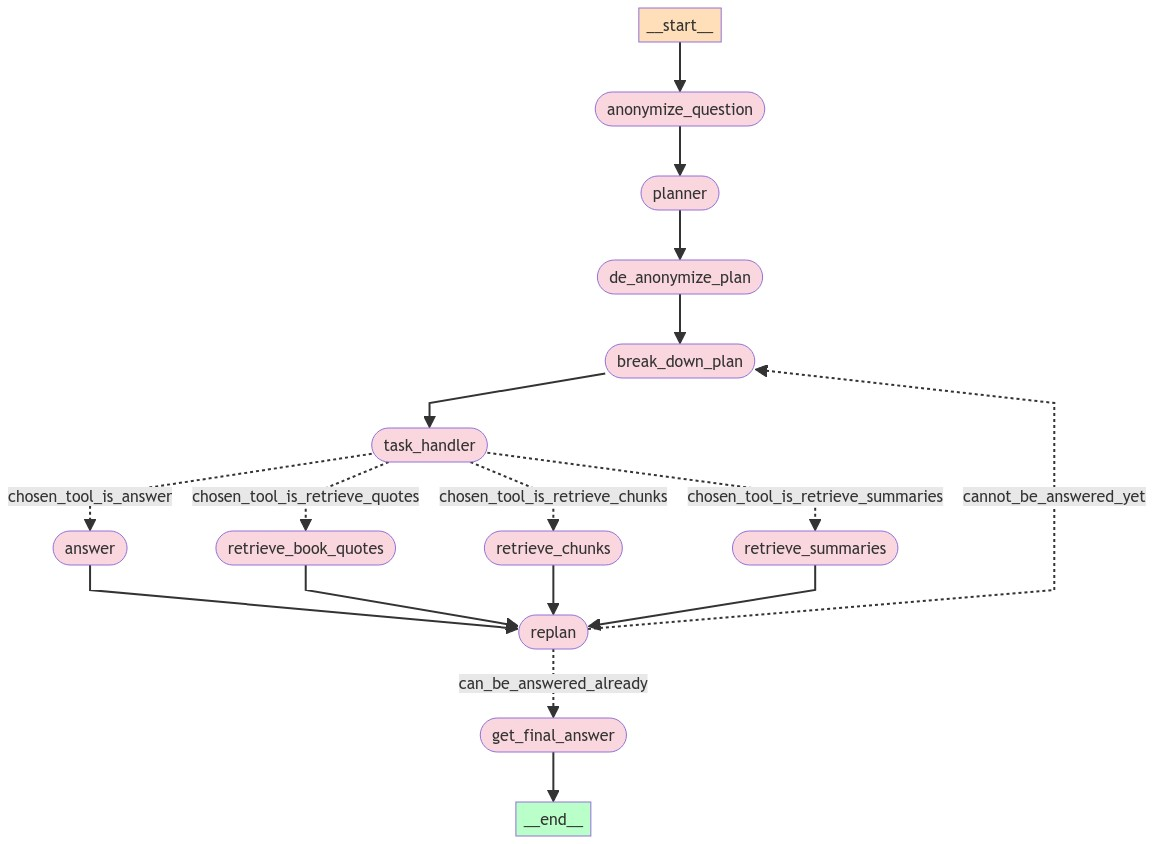

In [100]:
from langgraph.graph import StateGraph

agent_workflow = StateGraph(PlanExecute)

# Add the anonymize node
agent_workflow.add_node("anonymize_question", anonymize_queries)

# Add the plan node
agent_workflow.add_node("planner", plan_step)

# Add the break down plan node

agent_workflow.add_node("break_down_plan", break_down_plan_step)

# Add the deanonymize node
agent_workflow.add_node("de_anonymize_plan", deanonymize_queries)

# Add the qualitative chunks retrieval node
agent_workflow.add_node("retrieve_chunks", run_qualitative_chunks_retrieval_workflow)

# Add the qualitative summaries retrieval node
agent_workflow.add_node("retrieve_summaries", run_qualitative_summaries_retrieval_workflow)

# Add the qualitative book quotes retrieval node
agent_workflow.add_node("retrieve_book_quotes", run_qualitative_book_quotes_retrieval_workflow)


# Add the qualitative answer node
agent_workflow.add_node("answer", run_qualtative_answer_workflow)

# Add the task handler node
agent_workflow.add_node("task_handler", run_task_handler_chain)

# Add a replan node
agent_workflow.add_node("replan", replan_step)

# Add answer from context node
agent_workflow.add_node("get_final_answer", run_qualtative_answer_workflow_for_final_answer)

# Set the entry point
agent_workflow.set_entry_point("anonymize_question")

# From anonymize we go to plan
agent_workflow.add_edge("anonymize_question", "planner")

# From plan we go to deanonymize
agent_workflow.add_edge("planner", "de_anonymize_plan")

# From deanonymize we go to break down plan

agent_workflow.add_edge("de_anonymize_plan", "break_down_plan")

# From break_down_plan we go to task handler
agent_workflow.add_edge("break_down_plan", "task_handler")

# From task handler we go to either retrieve or answer
agent_workflow.add_conditional_edges("task_handler", retrieve_or_answer, {"chosen_tool_is_retrieve_chunks": "retrieve_chunks", "chosen_tool_is_retrieve_summaries":
                                                                           "retrieve_summaries", "chosen_tool_is_retrieve_quotes": "retrieve_book_quotes", "chosen_tool_is_answer": "answer"})

# After retrieving we go to replan
agent_workflow.add_edge("retrieve_chunks", "replan")

agent_workflow.add_edge("retrieve_summaries", "replan")

agent_workflow.add_edge("retrieve_book_quotes", "replan")

# After answering we go to replan
agent_workflow.add_edge("answer", "replan")

# After replanning we check if the question can be answered, if yes we go to get_final_answer, if not we go to task_handler
agent_workflow.add_conditional_edges("replan",can_be_answered, {"can_be_answered_already": "get_final_answer", "cannot_be_answered_yet": "break_down_plan"})

# After getting the final answer we end
agent_workflow.add_edge("get_final_answer", END)


plan_and_execute_app = agent_workflow.compile()

display(Image(plan_and_execute_app.get_graph(xray=True).draw_mermaid_png()))

### Run the sophisticated graph function

In [105]:
def execute_plan_and_print_steps(inputs, recursion_limit=45):
    """
    Execute the plan and print the steps.
    Args:
        inputs: The inputs to the plan.
        recursion_limit: The recursion limit.
    Returns:
        The response and the final state.
    """
    
    config = {"recursion_limit": recursion_limit}
    try:    
        for plan_output in plan_and_execute_app.stream(inputs, config=config):
            for _, agent_state_value in plan_output.items():
                pass
                print(f' curr step: {agent_state_value}')
        response = agent_state_value['response']
    except langgraph.pregel.GraphRecursionError:
        response = "The answer wasn't found in the data."
    final_state = agent_state_value
    print(text_wrap(f' the final answer is: {response}'))
    return response, final_state

### Examples

#### An example we want the model to fail

In [ ]:
input = {"question": "what did professor lupin teach?"}
final_answer, final_state = execute_plan_and_print_steps(input)

#### An example we want the model to succeed

In [ ]:
input = {"question": "what is the class that the proffessor who helped the villain is teaching?"}
final_answer, final_state = execute_plan_and_print_steps(input)

#### An example that demonstrates the CoT reasoning, when answering a question

In [ ]:
input = {"question": "how did harry beat quirrell?"}
final_answer, final_state = execute_plan_and_print_steps(input)

### Model Evaluation


In [102]:
questions = [
    "What is the name of the three-headed dog guarding the Sorcerer's Stone?",
    "Who gave Harry Potter his first broomstick?",
    "Which house did the Sorting Hat initially consider for Harry?",
    # "What is the name of Harry's owl?"
]
#     "How did Harry and his friends get past Fluffy?",
#     "What is the Mirror of Erised?",
#     "Who tried to steal the Sorcerer's Stone?",
#     "How did Harry defeat Quirrell?",
#     "What is Harry's parent's secret weapon against Voldemort?",
# ]

ground_truth_answers = [
    "Fluffy",
    "Professor McGonagall",
    "Slytherin",
    # "Hedwig",
    # "They played music to put Fluffy to sleep.",
    # "A magical mirror that shows the 'deepest, most desperate desire of our hearts.'",
    # "Professor Quirrell, possessed by Voldemort",
    # "Harry's mother's love protected him, causing Quirrell/Voldemort pain when they touched him.",
]

### Generating Answers and Retrieving Documents for Predefined Questions


In [ ]:
generated_answers = [] # To store the generated answers
retrieved_documents = [] # To store the retrieved documents
for question in questions:
    input = {"question": question} # The input to the plan
    print(f"Answering the question: {question}")
    final_answer, final_state = execute_plan_and_print_steps(input) # Execute the pipline 
    generated_answers.append(final_answer) # Append the generated answer
    retrieved_documents.append(final_state['aggregated_context']) # Append the retrieved documents

### Displaying Retrieved Documents and Generated Answers


In [ ]:
print(text_wrap(f'retrieved_documents: {retrieved_documents}\n'))
print(text_wrap(f'generated_answers: {generated_answers}'))

### Preparing Data and Conducting Ragas Evaluation


In [123]:
# Prepare data for Ragas evaluation
data_samples = {
    'question': questions,  # Replace with your list of questions
    'answer': generated_answers,  # Replace with your list of generated answers
    'contexts': retrieved_documents,  # Your retrieved_documents list
    'ground_truth': ground_truth_answers  # Replace with your list of ground truth answers
}

# Convert contexts to list of strings (if necessary)
data_samples['contexts'] = [list(context) for context in data_samples['contexts']]

dataset = Dataset.from_dict(data_samples)

# Evaluate using Ragas with the specified metrics
metrics = [
    answer_correctness,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_similarity
]
llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=4000)
score = evaluate(dataset, metrics=metrics, llm=llm)

# Print results and explanations
results_df = score.to_pandas()
print(results_df)

Evaluating: 100%|██████████| 15/15 [00:51<00:00,  3.44s/it]


                                            question                answer  \
0  What is the name of the three-headed dog guard...                Fluffy   
1        Who gave Harry Potter his first broomstick?  Professor McGonagall   
2  Which house did the Sorting Hat initially cons...             Slytherin   

                                            contexts          ground_truth  \
0  [I, n,  , C, h, a, p, t, e, r,  , S, i, x, t, ...                Fluffy   
1  [I, n,  , C, h, a, p, t, e, r,  , E, i, g, h, ...  Professor McGonagall   
2  [T, h, e,  , S, o, r, t, i, n, g,  , H, a, t, ...             Slytherin   

   answer_correctness  faithfulness  answer_relevancy  context_recall  \
0                 1.0           1.0          1.000000             1.0   
1                 1.0           1.0          0.946824             1.0   
2                 1.0           0.0          0.889830             0.0   

   answer_similarity  
0                1.0  
1                1.0  
2           

### Analyzing Metric Results from Ragas Evaluation


In [124]:
analyse_metric_results(results_df) # Analyse the results


**QUESTION**

**ANSWER**

**CONTEXTS**

**GROUND_TRUTH**

**ANSWER_CORRECTNESS**
Measures whether the generated answer is factually correct.
Score: 1.0000

**FAITHFULNESS**
Measures how well the generated answer is supported by the retrieved documents.
Score: 1.0000

**ANSWER_RELEVANCY**
Measures how relevant the generated answer is to the question.
Score: 1.0000

**CONTEXT_RECALL**
Measures the proportion of relevant documents that are successfully retrieved.
Score: 1.0000

**ANSWER_SIMILARITY**
Measures the semantic similarity between the generated answer and the ground truth answer.
Score: 1.0000
